## Estimation of subjective income risk profile using SCE data


- This notebook does the estimation of the Markov switching model for income risk perceptions using data from SCE 
- parameters to estimate:
   - $\tilde \Gamma_l$ and $\tilde \Gamma_h$ 
   - transition matrix $\Omega$ with $p$ and $q$ as the staying probability in low and high risk states, respectively.
  - where $\tilde \Gamma_l = \{\tilde \sigma^l_\psi,\tilde \sigma^l_\theta, \tilde{\mho^l}, \tilde{E^l}\}$ and $\tilde \Gamma_h = \{\tilde \sigma^h_\psi,\tilde \sigma^h_\theta, \tilde{\mho^h}, \tilde{E^h}\}$ where we impose the restriction that $\tilde \sigma^h_\psi > \tilde \sigma^l_\psi$ and $\tilde \sigma^h_\theta > \tilde \sigma^l_\theta$, $\tilde{\mho^h}>\tilde{\mho^l}$, and $\tilde{E^h}<\tilde{E^l}$.
 
  
Possible extensions
- Specific to group, such as age and education. 
- Conditional on macroeconomic conditions 

In [1]:
import numpy as np
from scipy.optimize import minimize 
import matplotlib.pyplot as plt 
import pandas as pd
import statsmodels.api as sm

#from utility import mkv2_M2Q, mkv2_Q2Y, mkv2_Y2M, mkv2_Y2Q

In [2]:
## some functions used for markov-related calculations 

def mkv2_M2Q(q,p):
    """
    input
    ======
    q and p are staying probs at monthly frequency 
    
    output
    ======
    qq and pp are quarterly counterparts 
    """
    
    ## different possibilities of staying in low state 
    qq0 = q**3   #LLLL
    qq1 = q*(1-q)*(1-p)    ## LLHL
    qq2 = (1-q)*(1-p)*q    ## LHLL
    qq3 = (1-q)*q*(1-q)    ## LHHL
    qq = qq0+qq1+qq2+qq3
    
    ## different possibilities of staying in high state
    
    pp0 = p**3             #HHHH
    pp1 = p*(1-p)*(1-q)    ## HHLH
    pp2 = (1-p)*(1-q)*p    ## HLHH
    pp3 = (1-q)*p*(1-p)    ## HLLH 
    pp = qq0+qq1+qq2+qq3
    
    return qq, pp


def mkv2_Q2Y(q,p):
    """
    input
    ======
    q and p are staying probs at quarterly frequency 
    
    output
    ======
    qq and pp are yearly counterparts 
    """
    
    ## 8 different possibilities of staying in low state 
    qq0 = q**4                               #L LLL L
    qq1 = q**2*(1-q)*(1-p)                   #L LLH L
    qq2 = q*(1-q)*(1-p)*q                    #L LHL L
    qq3 = q*(1-q)*p*(1-p)                    #L LHH L
    qq4 = (1-q)*(1-p)*q**2                   #L HLL L
    qq5 = (1-q)*(1-p)*(1-q)*(1-p)            #L HLH L
    qq6 = (1-q)*p*(1-p)*q                    #L HHL L
    qq7 = (1-q)*p**2*(1-p)                   #L HHH L
    qq = qq0+qq1+qq2+qq3+qq4+qq5+qq6+qq7
    
    ## 8 different possibilities of staying in high state
    
    pp0 = p**4                               #H HHH H
    pp1 = p**2*(1-p)*(1-q)                   #H HHL H
    pp2 = p*(1-p)*(1-q)*p                    #H HLH H
    pp3 = p*(1-p)*q*(1-q)                    #H HLL H
    pp4 = (1-p)*(1-q)*p**2                   #H LHH H
    pp5 = (1-p)*(1-q)*(1-p)*(1-q)            #H LHL H
    pp6 = (1-p)*q*(1-q)*p                    #H LLH H
    pp7 = (1-p)*q**2*(1-q)                   #H LLL H
    pp = pp0+pp1+pp2+pp3+pp4+pp5+pp6+pp7
    
    return qq, pp


def mkv2_Y2M(q,
             p):
    """
    input
    =====
    transition probs at the annual frequency 
    output
    =====
    monthly transition probs computed via continuous time Poisson rate 
    """
    
    ## to be completed 
    poisson_qM = -np.log(1-q)/12   ## = -np.log(1-qq)
    qq = 1-np.exp(-poisson_qM)
    
    poisson_pM = -np.log(1-p)/12   ## = -np.log(1-qq)
    pp = 1-np.exp(-poisson_pM)
    return qq,pp


def mkv2_Y2Q(q,
             p):
    """
    input
    =====
    transition probs at the annual frequency 
    output
    =====
    quarterly transition probs computed via continuous time Poisson rate 
    """
    
    ## to be completed 
    poisson_qM = -np.log(1-q)/3   ## = -np.log(1-qq)
    qq = 1-np.exp(-poisson_qM)
    
    poisson_pM = -np.log(1-p)/3   ## = -np.log(1-qq)
    pp = 1-np.exp(-poisson_pM)
    return qq,pp

In [3]:
class Markov2Switching:
    """
    A class that stores primitives for the Markov Regime Switching Model
    %%%% Model %%%%%%%
    % y_t = alpha+ beta * s_t + epsilon_t
    % y is the observed variable;
    % s_t =1 in high state; s_t = 0 in low state;
    % q=p(s_t=0|s_t-1=0)
    % p=p(s_t=1|s_t-1=1)
    % Transition Matrix from [s=0,s=1]' is [q,1-p;1-q,p] 
    % para_est stores all estimates of parameters. 
    %%%%%%%%%%%%%%%%%

    """

    def __init__(self,
                 Y = None,
                 paras = np.array([0.1,0.1,0.1,0.7,0.7]),
                 nb_var = 1,
                 state_dependence = False,
                 AR = 0):  
        
        ## count how many variables 
        self.nb_var = nb_var
        
        if AR==0:
            assert self.nb_var == int(len(paras)/5),'the nb of parameters needs to be equal to 5 x nb of variables'
        elif AR==1:
            assert self.nb_var == int(len(paras)/6),'the nb of parameters needs to be equal to 6 x nb of variables'
          
        self.paras = paras.reshape(self.nb_var,-1)
        
        self.Y = Y
        ## be careful with the order 
        self.αs = self.paras[:,0]
        self.βs = self.paras[:,1]
        self.σs = self.paras[:,2]
        self.qs = self.paras[:,3]
        self.ps = self.paras[:,4]
        if AR==0:
            self.ϕ1s =np.zeros(self.nb_var)
        elif AR==1:
            self.ϕ1s = paras[:,5]
        self.state_dependence = state_dependence
        self.AR = AR 
    
    ### pdf function of normal distribution 
    def norm_pdf(self,
                 x,    ## value of the rm 
                 μ,    ## mean of the nromal
                 σ):   ## std of the normal 
        """
        pdf of normal distribution mean μ and variance σ^2
        """
        x_new = (x-μ)/σ
        temp1 = 1/(np.sqrt(2*np.pi))
        temp2 = np.exp(-(x_new**2/2))
        return temp1*temp2 
    
    ## The functions below are help functions 
    ## that turn a hard constraint for parameters to a unconstrainted problem
    ## prob_func  from R -> [0,1]
    def prob_func(self,
                   x):
        """
        this bound function maps unconstrained x to y between 0 and 1
        """
        return np.exp(x)/(1+np.exp(x))     
    
    def prob_func_inv(self,
                     y):
        return np.log(y)-np.log(1-y)
    
    ## exp_func  from R --> [0,+infinity]
    def exp_func(self,
                 x):
        return np.exp(x)
    
    def exp_func_inv(self,
                     y):
        return np.log(y)
    
    def get_model_para(self,
                      para):
        """
        unconstrained parameters recast into model parameters with constraints
        """
        assert len(para)==self.nb_var*(5+self.AR),"the nb of parameters is incorrect"
        paras = para.reshape(self.nb_var,-1)
        
        αs = paras[:,0]
        βs = paras[:,1]
        #np.concatenate([self.exp_func(paras[0:2,1]),
        #                     np.array(-self.exp_func([paras[2,1]]))
        #                    ])
        σs = self.exp_func(paras[:,2])
        qs = self.prob_func(paras[:,3])
        ps = self.prob_func(paras[:,4])
        if self.AR==1:
            ϕ1s = self.prob_func(paras[:,5])
        else:
            ϕ1s = np.zeros(self.nb_var)
        return αs,βs,σs,qs,ps,ϕ1s
    
    def make_para_dict(self,
                      para):
        """
        a function that creates a dictionary of parameters with names
        """
        αs,βs,σs,qs,ps,ϕ1s =self.get_model_para(para)
            
        q = qs[0]
        p =ps[0]
        
        model_para ={}
        model_para['q']=q
        model_para['p']=p
        model_para['α']=αs
        model_para['β']=βs
        model_para['σ'] =σs
        model_para['ϕ1']=ϕ1s
                   
        return model_para
    
    def steady_state(self,
                      q,
                      p):
        return ((1-p)/(2-p-q),
                (1-q)/(2-p-q))
    
    
    ## Key function that computes log-likelihood for a list of time series of realized data
    def log_likelihood(self,
                       Y_list,   ## a list of multiple series 
                       para):
        
        """
        inputs
        ======
        Y: a list of independent univariate/multivariate (a vector) time series for which the log-likilihood is computed jointly
        para: parameters of the process sized of nb of vairalbes x nb of parameters, with the strictly set order of α,β,σ,q,p,ϕ1
        
        outputs
        =======
        llh_tot: total log-likelihood across all series
        update1_list: list of updating probs s=1|Y_t at time t;
        prdict1_list: list of prediction probs: s=1|Y_t-1 at time t-1;
        f1_list: list of predicted probs: y_t|y_t-1;
        """
        αs,βs,σs,qs,ps,ϕ1s = self.get_model_para(para)

        update1_list =[]
        prdict1_list =[]
        f1_list =[]
        
        
        ## starting from zero loglikelihood 
        
        llh_tot = 0.0
        

        q = qs[0]
        p = ps[0]
        
        for k in range(len(Y_list)):
            Y = Y_list[k]  ## Y is a 1-d or nb_var-d array 
            
            T = Y_list[k].shape[1] ## length of the series is not necessarily the same 
            
            ## this loops over all periods 
            llh = 0.0

            update0 = np.empty(T)
            update1 = np.empty(T)
            prdict1 = np.empty(T)
            f1 = np.empty(T)

            ## initilize the first period 
            update0[0], update1[0] = self.steady_state(q,   #p(s=0|Y_0) and  # p(s=1|Y_1)
                                                       p)   
            
            for t in range(1,T-1):
                prdict1[t] = (1-q)*update0[t-1]+p*update1[t-1]  #p(s_t=1|y_t-1);
                
                pdf_t_1 = prdict1[t]
                pdf_t_0 = (1-prdict1[t])
                
                ## loop over differen time series 
                for x in range(self.nb_var):
                    pdf_t_1 =pdf_t_1*self.norm_pdf(Y[x,t]-ϕ1s[x]*Y[x,t-1],αs[x]+βs[x],σs[x])  # f(y_t|s_t=1,Y_t-1)
                    pdf_t_0 =pdf_t_0*self.norm_pdf(Y[x,t]-ϕ1s[x]*Y[x,t-1],αs[x],σs[x]) # f(y_t|s_t=0,Y_t-1)
                
                f1[t]= pdf_t_1+pdf_t_0     # f1= f(y_t|Y_t-1)
                #print(f1[t])
                llh_pred = np.log(f1[t])     # log( f(y_t|Y_t-1))
                llh = llh + llh_pred    # llh_pred = log(f(y_t|Y_t-1))
                update1[t] = pdf_t_1/(pdf_t_1+ pdf_t_0)  # p(s_t=0|y_t-1) 
                update0[t] = 1-update1[t]                # p(s_t=1|y_t-1)
                
            ## merge those probabilities 
            
            update1_list.append(update1) 
            prdict1_list.append(prdict1)
            f1_list.append(f1)
        
            ## sum across agents 
            llh_tot = llh_tot+llh
        
        return llh_tot,update1_list,prdict1_list,f1_list

In [4]:
## create the model 
mkv2 = Markov2Switching(AR=0,
                        nb_var=1)

### Test using fake simulated data with known parameters

In [5]:
import quantecon as qe
from quantecon import MarkovChain

## fake parameters 
α_fake = 0.1
β_fake = 0.2
σ_fake = 0.8
q_fake = 0.7
p_fake = 0.6
ϕ1_fake = 0.0

mkv_mat = np.array([[q_fake,1-q_fake],
                    [1-p_fake,p_fake]])

para_fake = np.array([α_fake,
                      β_fake,
                      mkv2.exp_func_inv(σ_fake),
                      mkv2.prob_func_inv(q_fake),
                      mkv2.prob_func_inv(p_fake),
                      #mkv2.prob_func_inv(ϕ1_fake)
                     ])
T_fake = 12
nb_sim = 300

fake_regime_h_list=[]
fake_data_list = []

prob_ss0, prob_ss1 = mkv2.steady_state(q_fake,
                                       p_fake)

init_sim = (np.random.uniform(0,1,nb_sim)<=prob_ss1)*1

for i in range(nb_sim):
    mc = qe.MarkovChain(mkv_mat)
    regime_h = mc.simulate(ts_length=T_fake+1,
                          init= init_sim[i])
    regime_l = 1-regime_h
    shocks = np.random.randn(T_fake+1)*σ_fake
    constant_l = α_fake
    constant_h = α_fake+β_fake
    y = (regime_l*constant_l+regime_h*constant_h)+shocks
    ## AR1 process
    for t in range(1,T_fake):
        y[t]= ϕ1_fake*y[t-1]+y[t]
    
    ## add to the list 
    this_y_2d = y[1:].reshape(-1,len(y[1:]))
    fake_data_list.append(this_y_2d)
    fake_regime_h_list.append(regime_h)
index = range(T_fake)

OMP: Info #270: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


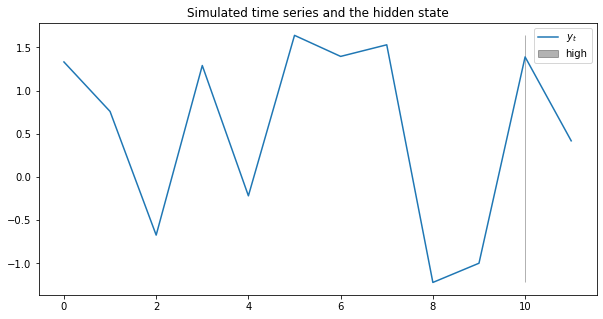

In [6]:
## plot the simulated data 
if len(fake_data_list)==1:
    random_id = 0
else:
    random_id = np.random.randint(0,len(fake_data_list)-1)
    
## get the random data and regime sequence
y = fake_data_list[random_id].T
regime_h = fake_regime_h_list[random_id]

plt.figure(figsize=(10,5))
plt.title('Simulated time series and the hidden state')
plt.plot(y,
         label=r'$y_t$')
plt.fill_between(index,
                 np.min(y),
                 np.max(y),
                 where=regime_h[1:],
                 color="k", 
                 alpha=0.3,
                label='high')
plt.legend(loc=1)

In [7]:
## plot log-likelihood based on the true parameters 

llh,filter1,pr1,pdf = mkv2.log_likelihood(fake_data_list,
                                          para_fake)

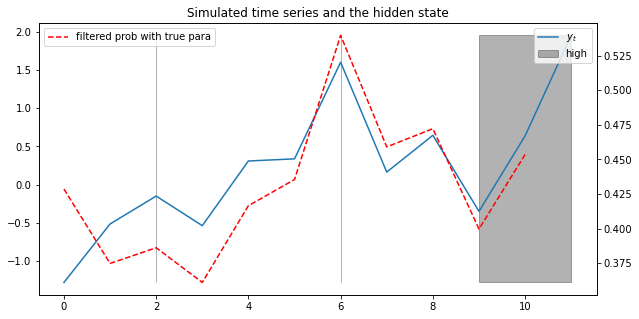

In [8]:
## plot the simulated data 
if len(fake_data_list)==1:
    random_id = 0
else:
    random_id = np.random.randint(0,len(fake_data_list)-1)
    
## get the random data and regime sequence
y = fake_data_list[random_id].T
regime_h = fake_regime_h_list[random_id]


## plot everything 
fig, ax = plt.subplots(figsize=(10,5))
ax.set_title('Simulated time series and the hidden state')

## time series of y 
ax.plot(y,
         label=r'$y_t$')
## regime 
ax.fill_between(index,
                 np.min(y),
                 np.max(y),
                 where=regime_h[1:],
                 color="k", 
                 alpha=0.3,
                label='high')
ax2 = ax.twinx()
## filter prob
ax2.plot(filter1[random_id][:-1],
         'r--',
        label='filtered prob with true para')
ax.legend(loc=1)
ax2.legend(loc=2)

In [9]:
## try estimation

obj = lambda para: -mkv2.log_likelihood(fake_data_list,
                                        para)[0]   ## only the first output


## tight bounds for some parameters 
sigma_ub = np.mean([np.std(np.array(x)) for x in fake_data_list])
sigma_inv_ub = mkv2.exp_func_inv(sigma_ub)
q_lb = 0.5  ## persistent 
q_inv_lb = mkv2.prob_func_inv(q_lb) 
p_lb = 0.5 ## persistent 
p_inv_lb = mkv2.prob_func_inv(p_lb)

## estimation 
#guess = (0.2,0.3,0.1,0.1,0.4)
guess = para_fake
#bounds = ((-0.3,1),(-2,2),(-2,2),(-4,1),(-4,1),) 
bounds = ((None,None),(0.0,None),(-1,sigma_inv_ub),(None,None),(None,None),)

result = minimize(obj,
                    x0 = guess,
                    method='SLSQP',   #SLSQP
                    bounds = bounds,
                    options={'disp': False,
                            }
                   )
print('success? ',result['success'])
para_est = result['x']


para_fake_dict = mkv2.make_para_dict(para_fake)
para_guess_dict = mkv2.make_para_dict(guess)
para_est_dict = mkv2.make_para_dict(para_est)


#results
print("fake TRUE parameters\n",para_fake_dict)
print("initial guess of the parameters\n",para_guess_dict)
print("estimated parameters\n",para_est_dict)

success?  True
fake TRUE parameters
 {'q': 0.7, 'p': 0.5999999999999999, 'α': array([0.1]), 'β': array([0.2]), 'σ': array([0.8]), 'ϕ1': array([0.])}
initial guess of the parameters
 {'q': 0.7, 'p': 0.5999999999999999, 'α': array([0.1]), 'β': array([0.2]), 'σ': array([0.8]), 'ϕ1': array([0.])}
estimated parameters
 {'q': 0.5702441137654248, 'p': 0.035392725538131685, 'α': array([0.00686583]), 'β': array([0.56344671]), 'σ': array([0.75836768]), 'ϕ1': array([0.])}


In [10]:
#Based on estimates of parameters and data; compute filtered probabilities

llh,filter1,pr1,pdf = mkv2.log_likelihood(fake_data_list,
                                          para_est)
# filter1: prob of good state;
# pr1: predicted prob of good state 

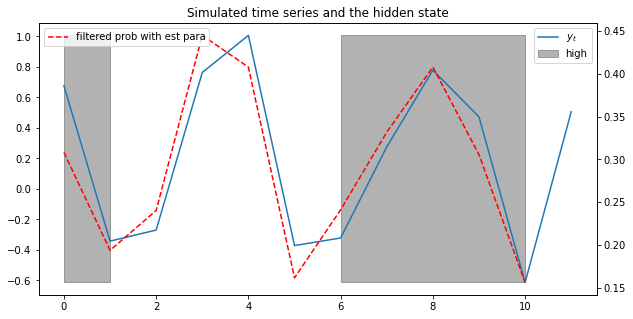

In [11]:
## plot the simulated data 
if len(fake_data_list)==1:
    random_id = 0
else:
    random_id = np.random.randint(0,len(fake_data_list)-1)
    
## get the random data and regime sequence
y = fake_data_list[random_id].T
regime_h = fake_regime_h_list[random_id]


## plot everything 

fig, ax = plt.subplots(figsize=(10,5))
ax.set_title('Simulated time series and the hidden state')

## time series of y 
ax.plot(y,
         label=r'$y_t$')
## regime 
ax.fill_between(index,
                 np.min(y),
                 np.max(y),
                 where=regime_h[1:],
                 color="k", 
                 alpha=0.3,
                label='high')
ax2 = ax.twinx()
## filter prob
ax2.plot(filter1[random_id][:-1],
         'r--',
        label='filtered prob with est para')
ax.legend(loc=1)
ax2.legend(loc=2)

### Estimation of SCE data

In [12]:
import pandas as pd
import statsmodels.formula.api as smf
import numpy as np

## precision of showing float  
pd.options.display.float_format = '{:,.3f}'.format

In [13]:
## import data 
dataset = pd.read_stata('../SurveyData/SCE/IncExpSCEProbIndM.dta')   

## variables 
vars_id = ['userid','date']
moms_nom = ['Q24_mean','Q24_iqr','Q24_var']
moms_real = ['Q24_rmean','Q24_rvar']
ue_risks = ['Q13new','Q22new']
vars_demog = ['D6']   ## level of income, 11 groups 

vars_job = ['Q10_1',  # full-time 
            'Q10_2',  # part-time
            'Q12new'] ## =1 worked for others; = 2 self-employment 

vars_demog_sub = ['Q32',  ## age 
                  'Q33',  ## gender 
                  'Q36',  ## education (1-8 low to high, 9 other)
                  'educ_gr',##education group (1-3)
                  'byear',
                 'nlit'] ## year of birth

vars_all_reg_long = (vars_id+moms_nom + moms_real+ue_risks+vars_demog+vars_demog_sub+vars_job)

## select dataset 
SCEM = dataset[vars_all_reg_long]


SCEM = SCEM.rename(columns={'Q24_mean': 'incexp',
                           'Q24_var': 'incvar',
                           'Q24_iqr': 'inciqr',
                           'Q24_rmean':'rincexp',
                           'Q24_rvar': 'rincvar',
                           'Q13new':'UE_s',
                           'Q22new':'UE_f'
                           })


SCEM = SCEM.rename(columns = {'D6':'HHinc',
                              'Q10_1':'fulltime',
                              'Q10_2':'parttime',
                              'Q12new':'selfemp',
                              'Q32':'age',
                              'Q33':'gender',
                              'Q36':'educ'})

SCEM = SCEM.dropna(subset=['date'])

## add year and month variable 
SCEM['year'] = SCEM.date.dt.year
SCEM['month'] = SCEM.date.dt.month 


## new variables 
SCEM['age2']=SCEM['age']**2
SCEM['age3']=SCEM['age']**3
SCEM['age4']=SCEM['age']**4

## take the log 

SCEM['lrincvar'] = np.log(SCEM['rincvar'])


### some data transformation 

SCEM['UE_s'] = SCEM['UE_s']/100
SCEM['UE_f'] = SCEM['UE_f']/100

SCEM['U2U_prob'] = 1-SCEM['UE_f']   #. 1- prob of find a job
SCEM['E2E_prob'] = 1- SCEM['UE_s']*(1-SCEM['UE_f'])   ## 1- prob(loses the job and not finding one)


## trucate 0 and 1s for probs 
SCEM['U2U_prob_truc'] = np.where((SCEM['U2U_prob']==1),1-1e-10,SCEM['U2U_prob'])
SCEM['U2U_prob_truc'] = np.where((SCEM['U2U_prob']==0),0+1e-10,SCEM['U2U_prob'])

SCEM['E2E_prob_truc'] = np.where((SCEM['E2E_prob']==1),1-1e-10,SCEM['E2E_prob'])
SCEM['E2E_prob_truc'] = np.where((SCEM['E2E_prob']==0),0+1e-10,SCEM['E2E_prob'])


### transform 0-1 prob to a R 

prob_inv_func = lambda x: np.log(x)-np.log(1-x)
SCEM['U2U_prob_e'] = SCEM['U2U_prob_truc'].apply(prob_inv_func)
SCEM['E2E_prob_e'] =  SCEM['E2E_prob_truc'].apply(prob_inv_func)

In [14]:
## first step regression

vars_list = ['lrincvar',
            'U2U_prob',
            'E2E_prob']  

for var in vars_list:
    ## demeaned 
    SCEM[var+'_dm'] = SCEM[var]-SCEM.groupby('userid')[var].transform('mean')
    
    ## run a panel regression to get the residuls 
    model = smf.ols(formula = var+'~ C(date)+C(HHinc)+C(gender)+age2+age3+age4+C(educ_gr)',
                data = SCEM)
    result = model.fit()
    residuls = result.resid
    SCEM[var+'_rd'] = residuls

In [15]:
## convert the panel data of rincvar into a list of time series sequence
vars_rd_list = ['lrincvar_rd',
                'U2U_prob',
                'E2E_prob']  

In [16]:
## convert it to a list of arrays storing all time series data for each individual

SCEM_sub = SCEM[['userid']+vars_rd_list].dropna(how='any')

unique_ids = list(SCEM_sub['userid'].unique())

SCE_list = [SCEM_sub[SCEM_sub['userid']==ID][vars_rd_list].T.to_numpy() for ID in unique_ids]

SCE_list = [x for x in SCE_list if ~np.isnan(np.array(x)).any() and x.shape[1]>=3]

print('how many invidividuals have answers in successive months?',len(SCE_list))

how many invidividuals have answers in successive months? 4916


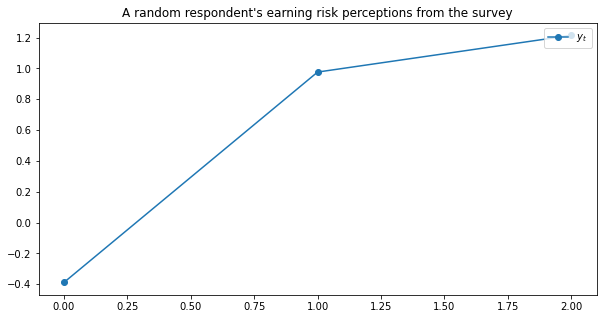

In [17]:
## plot the simulated data 
random_id = np.random.randint(0,len(SCE_list)-1)

plt.figure(figsize=(10,5))
plt.title("A random respondent's earning risk perceptions from the survey")
plt.plot(SCE_list[random_id][0,:],
         'o-',
         label=r'$y_t$')
plt.legend(loc=1)

In [18]:
## create the model 
SCE_mkv2 = Markov2Switching(AR=0,
                            paras = np.array([0.1,0.1,0.1,0.7,0.7,
                                             0.1,0.1,0.1,0.7,0.7,
                                             0.1,-0.1,0.1,0.7,0.7,]),
                           nb_var = 3)

## objective func
SCE_obj = lambda para: -SCE_mkv2.log_likelihood(SCE_list,
                                                para)[0]   ## only the first output

In [20]:
## impose some bounds for some parameter based on informed priors


## the size of the shock cannot exceed the sample variation
sigma_ub0 = np.mean([np.std(np.array(x[0,:])) for x in SCE_list])
sigma_inv_ub0 = SCE_mkv2.exp_func_inv(sigma_ub0)

sigma_ub1 = np.mean([np.std(np.array(x[1,:])) for x in SCE_list])
sigma_inv_ub1 = SCE_mkv2.exp_func_inv(sigma_ub1)

sigma_ub2 = np.mean([np.std(np.array(x[2,:])) for x in SCE_list])
sigma_inv_ub2 = SCE_mkv2.exp_func_inv(sigma_ub1)

## staying probabilities of both 2 states are above half, indicating persistency 
q_lb = 0.5  ## persistent 
q_inv_lb =SCE_mkv2.prob_func_inv(q_lb) 
p_lb = 0.5 ## persistent 
p_inv_lb =SCE_mkv2.prob_func_inv(p_lb)

## estimation 
guess = np.array([0.2,0.4,-0.5,0.1,0.4,
                0.2,0.4,-2,0.1,0.4,
                0.2,-0.1,-2,0.1,0.4])

bounds = ((None,None),(0.0,None),(-1,sigma_inv_ub0),(q_inv_lb,None),(p_inv_lb,None),
         (None,None),(0.0,None),(-4,sigma_inv_ub1),(None,None),(None,None),
         (None,None),(None,0.0),(-4,sigma_inv_ub2),(None,None),(None,None),)


result = minimize(SCE_obj,
                  x0 = guess,
                  method='SLSQP',   #SLSQP
                  bounds = bounds,
                  options={'disp': True,
                            'maxiter':5000}
                   )
print('success? ',result['success'])
SCE_para_est = result['x']
## get alpha, beta, sigma, q, p 


## get model parameters 
guess_para_model = SCE_mkv2.make_para_dict(guess)
SCE_para_model_est = SCE_mkv2.make_para_dict(SCE_para_est)


#results
print("initial guess of the parameters\n",guess_para_model)
print("estimated parameters\n",SCE_para_model_est)

/var/folders/39/ks6jc__9375c2fl7h7pwq5jh0000gn/T/ipykernel_8810/2870293738.py:68: RuntimeWarning: overflow encountered in exp
  return np.exp(x)/(1+np.exp(x))
/var/folders/39/ks6jc__9375c2fl7h7pwq5jh0000gn/T/ipykernel_8810/2870293738.py:68: RuntimeWarning: invalid value encountered in true_divide
  return np.exp(x)/(1+np.exp(x))
/var/folders/39/ks6jc__9375c2fl7h7pwq5jh0000gn/T/ipykernel_8810/2870293738.py:195: RuntimeWarning: divide by zero encountered in log
  llh_pred = np.log(f1[t])     # log( f(y_t|Y_t-1))
/var/folders/39/ks6jc__9375c2fl7h7pwq5jh0000gn/T/ipykernel_8810/2870293738.py:197: RuntimeWarning: invalid value encountered in double_scalars
  update1[t] = pdf_t_1/(pdf_t_1+ pdf_t_0)  # p(s_t=0|y_t-1)
/var/folders/39/ks6jc__9375c2fl7h7pwq5jh0000gn/T/ipykernel_8810/2870293738.py:128: RuntimeWarning: invalid value encountered in double_scalars
  return ((1-p)/(2-p-q),
/var/folders/39/ks6jc__9375c2fl7h7pwq5jh0000gn/T/ipykernel_8810/2870293738.py:129: RuntimeWarning: invalid value 

Optimization terminated successfully    (Exit mode 0)
            Current function value: 215307.090394342
            Iterations: 15
            Function evaluations: 239
            Gradient evaluations: 11
success?  True
initial guess of the parameters
 {'q': 0.52497918747894, 'p': 0.598687660112452, 'α': array([0.2, 0.2, 0.2]), 'β': array([ 0.4,  0.4, -0.1]), 'σ': array([0.60653066, 0.13533528, 0.13533528]), 'ϕ1': array([0., 0., 0.])}
estimated parameters
 {'q': 0.5538380825054681, 'p': 0.996805382073673, 'α': array([-1.59861293, -0.39612487,  1.73622263]), 'β': array([ 1.47006692,  0.83255116, -0.8002469 ]), 'σ': array([0.60642316, 0.13305097, 0.13302271]), 'ϕ1': array([0., 0., 0.])}


In [21]:
## get the kappa 

risks_est = pd.read_stata('../OtherData/sipp/sipp_history_vol_decomposed.dta')
## risks of permanent and transitory component 

σ_ψ_q_sipp = np.sqrt(risks_est['permanent']**2*3)
σ_θ_q_sipp = np.sqrt(risks_est['permanent']**2/3)

## p/t ratio 
kappas_sipp  = risks_est['permanent']/risks_est['transitory']
kappa_sipp = np.median(kappas_sipp.dropna())
kappa = kappa_sipp ## ratio of permanent and transitory risks 

In [22]:
## create a dictionary for storing parameters 

model_para_est = {}

############################################
## from yeraly to monthly risk then to quarterly 
############################################

model_para_est['q'],model_para_est['p'] = mkv2_M2Q(SCE_para_model_est['q'],
                                                   SCE_para_model_est['p'])

alpha = SCE_para_model_est['α'][0]
beta = SCE_para_model_est['β'][0]

model_para_est['\tilde\sigma_\psi^l'] = np.sqrt(3*np.exp(alpha)/(12+1/(12*kappa**2)))
model_para_est['\tilde\sigma_\theta^l'] =  1/3*model_para_est['\tilde\sigma_\psi^l']/kappa
model_para_est['\tilde\sigma_\psi^h'] =  np.sqrt(3*np.exp(alpha+beta)/(12+1/(12*kappa**2)))
model_para_est['\tilde\sigma_\theta^h'] =  1/3*model_para_est['\tilde\sigma_\psi^h']/kappa


model_para_est['\tilde \mho^l'],model_para_est['\tilde E^l'] = mkv2_Y2Q(SCE_para_model_est['α'][1],
                                                                        SCE_para_model_est['α'][2])

model_para_est['\tilde \mho^h'], model_para_est['\tilde E^h']=  mkv2_Y2Q(SCE_para_model_est['α'][1]+SCE_para_model_est['β'][1],
                                                                         SCE_para_model_est['α'][2]+SCE_para_model_est['β'][2])

print('quarterly SCE parameters\n',model_para_est)

quarterly SCE parameters
 {'q': 0.28170847347106975, 'p': 0.28170847347106975, '\tilde\\sigma_\\psi^l': 0.2245568799995006, '\tilde\\sigma_\theta^l': 0.04352417241587627, '\tilde\\sigma_\\psi^h': 0.46832499893231017, '\tilde\\sigma_\theta^h': 0.09077191489408058, '\tilde \\mho^l': -0.11765582893180815, '\tilde E^l': nan, '\tilde \\mho^h': 0.17399329270600905, '\tilde E^h': 0.5999494571472179}


/var/folders/39/ks6jc__9375c2fl7h7pwq5jh0000gn/T/ipykernel_8810/4143294826.py:104: RuntimeWarning: invalid value encountered in log
  poisson_pM = -np.log(1-p)/3   ## = -np.log(1-qq)


In [23]:
## convert to a dataframe 


SCE_para_est_df = pd.DataFrame.from_dict(model_para_est,
                                         orient='index',
                                         dtype=None, 
                                         columns=['baseline']
                                        )

## output tables 

beginningtex = """
\\begin{table}[p]
\\centering
\\begin{adjustbox}{width=0.3\\textwidth}
\\begin{threeparttable}
\\caption{Estimated subjective risk perceptions}
\\label{tab:PRMarkovEst}"""

endtex = """\\begin{tablenotes}\item This table reports estimates of the parameters 
for the 2-state Markov switching model of subjective risk perceptions. Risks are at the monthly frequency. 
\\end{tablenotes}
\\end{threeparttable}
\\end{adjustbox}
\\end{table}"""


## write to latex 
f = open('../Tables/latex/PRMarkovEst.tex', 'w')
f.write(beginningtex)
tb_ltx = SCE_para_est_df.to_latex()
f.write(tb_ltx)
f.write(endtex)
f.close()

In [24]:
## presentable tables 


index_names = ['$q$',
              '$p$',
              '$\tilde\sigma^l_\psi$',
              '$\tilde\sigma^l_\theta$',
              '$\tilde\sigma^h_\psi$',
              '$\tilde\sigma^h_\theta$',
              '$\tilde \mho^l$',
              '$\tilde \mho^h$',
              '$\tilde E^l$',
              '$\tilde E^h$']


SCE_para_est_df.index = index_names
SCE_para_est_df

,baseline
$q$,0.282
$p$,0.282
$\tilde\sigma^l_\psi$,0.225
$\tilde\sigma^l_\theta$,0.044
$\tilde\sigma^h_\psi$,0.468
$\tilde\sigma^h_\theta$,0.091
$\tilde \mho^l$,-0.118
$\tilde \mho^h$,NaN
$\tilde E^l$,0.174
$\tilde E^h$,0.600


In [25]:
## save it to a pickle file 
SCE_para_est_df.to_pickle('subjective_profile_est.pkl')

In [28]:
"""
import pickle

with open("parameters.txt", "rb") as fp:
    lc_paras = pickle.load(fp)
    
for key in model_para_est.keys():
    lc_paras[key] = model_para_est[key]
    
print(lc_paras)
with open("parameters.txt", "wb") as fp:
    pickle.dump(lc_paras, fp)
"""

{'ρ': 1, 'β': 0.9949620563926881, 'P': array([[0.18, 0.82],
       [0.04, 0.96]]), 'z_val': array([0., 1.]), 'σ_ψ': 0.09045340337332908, 'σ_θ': 0.2, 'U': 0.0, 'LivPrb': 0.99375, 'σ_ψ_2mkv': array([0.01, 0.02]), 'σ_θ_2mkv': array([0.02, 0.04]), 'R': 1.0024906793143211, 'W': 1.0, 'T': 160, 'L': 240, 'G': array([1.        , 1.00621092, 1.01242185, 1.01863277, 1.02484369,
       1.02443039, 1.0240171 , 1.0236038 , 1.0231905 , 1.02278841,
       1.02238631, 1.02198422, 1.02158213, 1.02119136, 1.02080059,
       1.02040982, 1.02001905, 1.01963976, 1.01926047, 1.01888117,
       1.01850188, 1.01813418, 1.01776648, 1.01739877, 1.01703107,
       1.01667506, 1.01631904, 1.01596302, 1.015607  , 1.01526287,
       1.01491874, 1.01457462, 1.01423049, 1.0138984 , 1.01356632,
       1.01323423, 1.01290214, 1.01258209, 1.01226205, 1.011942  ,
       1.01162195, 1.01131424, 1.01100653, 1.01069883, 1.01039112,
       1.01009578, 1.00980043, 1.00950509, 1.00920975, 1.00892699,
       1.00864422, 1.00836

## Other tests of the code

### test using macro time series: U.S.  real GDP growth rate 



In [25]:
import pandas_datareader.data as web
import datetime

start = datetime.datetime(1945, 1, 1)
end = datetime.datetime(2019, 12, 31)


rec = web.DataReader("USREC", 
                     "fred", 
                     start, 
                     end)
gdp = web.DataReader('GDPC1',
                     'fred',
                     start,
                     end)
gdp_gr = gdp.pct_change().dropna()
gdp_gr.index = pd.DatetimeIndex(gdp_gr.index, freq="QS")

ConnectionError: HTTPSConnectionPool(host='fred.stlouisfed.org', port=443): Max retries exceeded with url: /graph/fredgraph.csv?id=USREC (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7ffd05a0fa60>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known'))

In [ ]:
## use statsmodels 

mod_hamilton = sm.tsa.MarkovAutoregression(
    gdp_gr, 
    k_regimes=2, 
    order= 4, 
    switching_ar=False
)
res_hamilton = mod_hamilton.fit()

In [ ]:
res_hamilton.summary()

In [ ]:
fig, axes = plt.subplots(2, figsize=(7, 7))
ax = axes[0]
ax.plot(res_hamilton.filtered_marginal_probabilities[0])
ax.fill_between(rec.index, 
                0, 
                1, 
                where=rec["USREC"].values, 
                color="k", 
                alpha=0.1)
ax.set_xlim(gdp_gr.index[4], gdp_gr.index[-1])
ax.set(title="Filtered probability of recession")

ax = axes[1]
ax.plot(res_hamilton.smoothed_marginal_probabilities[0])
ax.fill_between(rec.index, 0, 1, where=rec["USREC"].values, color="k", alpha=0.1)
ax.set_xlim(gdp_gr.index[4], gdp_gr.index[-1])
ax.set(title="Smoothed probability of recession")

fig.tight_layout()

In [ ]:
## estimation using codes here 

mkv2_gdp = Markov2Switching(AR=1,
                           nb_var=1)
fake_data_list = [np.array(gdp_gr['GDPC1'])]

obj = lambda para: -mkv2_gdp.log_likelihood(fake_data_list,
                                        para)[0]   ## only the first output

## estimation 
guess = (0.0,0.2,0.4,0.2,0.2,0.9)
#bounds = [(None,None),(None,None),(0.03,1.0),(0.0,1.0),(0.0,1.0)] 

para_est = minimize(obj,
                    x0=guess,
                    method='CG',
                    options={'disp': True,
                            #'maxls':40,
                            #'ftol': 2.220446049250313e-11
                            }
                   )['x']

#results
print('Estimated model parameters:',[round(x,2) for x in mkv2_gdp.get_model_para(para_est)])

llh,filter1,pr1,pdf = mkv2_gdp.log_likelihood(fake_data_list,
                                          para_est)

In [ ]:
## plot the time series 

lw = 2
figsize = (15,5)
fontsize = 10

## plot 
fig, ax = plt.subplots(figsize = figsize)
ax2 = ax.twinx()
ax.plot(gdp_gr.index[2:-1],
        gdp_gr[2:-1],
        color='black',
           lw= lw,
           label= 'gdp growth ')
ax2.plot(gdp_gr.index[2:-1],
         filter1[0][2:-1],
         'r-',
         lw = lw,
         label = 'filter prob (RHS)')
ax.legend(loc = 2,
         fontsize = fontsize)
ax.set_xlabel("month",fontsize = fontsize)
ax.grid()
ax.set_ylabel('% growth',fontsize = fontsize)
ax.tick_params(axis='both', 
               which='major', 
               labelsize = fontsize)
ax2.tick_params(axis='both', 
               which='major', 
               labelsize = fontsize)
ax2.fill_between(rec.index, 
                min(filter1[0][1:-1]), 
                max(filter1[0][1:-1]), 
                where=rec["USREC"].values, 
                color="k", 
                alpha=0.1)
ax2.legend(loc = 1,
          fontsize = fontsize)